In [1]:
import os
os.chdir('..')

In [2]:
import utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

# import some useful functions (they are available in utils.py)
from utils import *

In [4]:
time_factor = np.load("data/time_factor.npy")
neuron_factor = np.load("data/neuron_factor.npy")
trial_factor = np.load("data/trial_factor.npy")
latent = np.load("data/latent.npy")
observed = np.load("data/observed.npy")

In [40]:
X.shape

(500, 50, 100)

In [41]:
factors_tl.shape

(500, 50, 100)

In [47]:
factors_tl

(weights, factors) : rank-3 KruskalTensor of shape (500, 50, 100) 

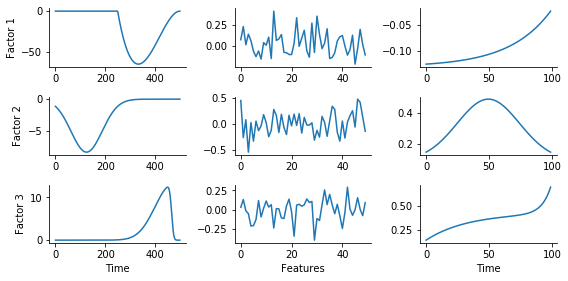

In [42]:
plot_factors(factors_tl[1])

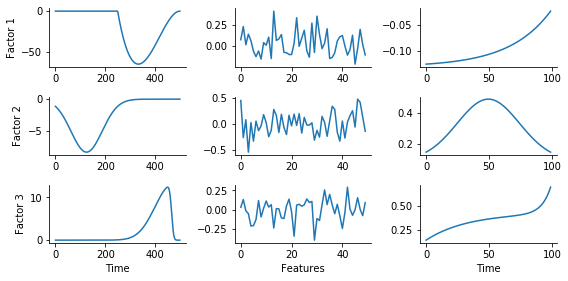

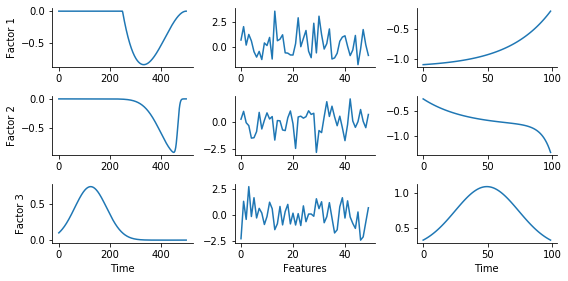

In [5]:
# Specify the tensor, and the rank (np. of factors)
X, rank = observed, 3

# Perform CP decompositon using TensorLy
factors_tl = parafac(X, rank=rank)


# Perform CP decomposition using tensortools
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

# Reconstruct M, with the result of each library
M_tl = reconstruct(factors_tl[1])
M_tt = reconstruct(factors_tt)

# plot the decomposed factors
plot_factors(factors_tl[1])
plot_factors(factors_tt)

In [6]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):

    # a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))

        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())

    return a.T, b.T, c.T

In [7]:
factors_np = decompose_three_way(X, rank)

In [8]:
factors_np[0].shape

(500, 3)

In [9]:
factors_np[1].shape

(50, 3)

In [10]:
factors_np[2].shape

(100, 3)

In [11]:
factors_actual = (time_factor, neuron_factor, trial_factor)

In [12]:
utils

<module 'utils' from '/Users/calebchiam/Documents/GitHub/Cornell-Conversational-Analysis-Toolkit/convokit/tensors/utils.py'>

In [16]:
actual_tensor = reconstruct(factors_actual)

In [17]:
new_tensor = reconstruct(factors_np)

In [18]:
new_tensor.shape

(500, 50, 100)

In [22]:
a = actual_tensor - new_tensor

In [28]:
tensor_tt = reconstruct(factors_tt)

In [35]:
tensor_tl = reconstruct(factors_tl[1])

In [27]:
factors_tt[0].shape

(500, 3)

In [30]:
np.linalg.norm(actual_tensor - tensor_tt)

0.07999962110037367

In [36]:
np.linalg.norm(actual_tensor - new_tensor)

6.915177023958563e-05

In [37]:
np.linalg.norm(actual_tensor - tensor_tl)

0.0003497942912887411

In [ ]:
np.linalg.norm(actual_tensor - tensor_tt)